In [1]:
# Importing packages and libraries
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',120)
pd.set_option('display.max_rows',120)


In [2]:
# Read Data
features = pd.read_csv('features.csv')
train=pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
test=pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

In [3]:
# review the data
print(features.head())
print('--------- \n')
print(train.head())
print('--------- \n')
print(stores.head())
print('--------- \n')
print(test.head())
print('--------- \n')
print(sample_submission.head())

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  
--------- 

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     

In [4]:
# No features contained in dataset <test>, it only has store,department, date and holiday.
# Explore if the features (Temperature, Fuel Price, Markdowns, CPI and Unemployment) can affect the <weekly_sales>

In [5]:
#Data Cleaning
features.shape, train.shape, stores.shape, test.shape

((8190, 12), (421570, 5), (45, 3), (115064, 4))

In [6]:
feature_store = features.merge(stores, how='inner', on = 'Store')
train = train.merge(feature_store, how = 'inner', on=['Store', 'Date','IsHoliday'])
test = test.merge(feature_store, how = 'inner', on =['Store','Date','IsHoliday'])
train=train.copy()
test=test.copy()
# adding datetime into the table as features
train['Date'] = pd.to_datetime(train['Date'])
train['Day'] = train['Date'].dt.day
train['Week']=train['Date'].dt.week
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year
train.replace({'A':1,'B':2,'C':3},inplace=True)

test['Date'] = pd.to_datetime(test['Date'])
test['Day'] = test['Date'].dt.day
test['Week']=test['Date'].dt.week
test['Month'] = test['Date'].dt.month
test['Year'] = test['Date'].dt.year
test.replace({'A':1,'B':2,'C':3},inplace=True)

print(train.head())
print('--------- \n')
print(test.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     2 2010-02-05      50605.27      False        42.31       2.572   
2      1     3 2010-02-05      13740.12      False        42.31       2.572   
3      1     4 2010-02-05      39954.04      False        42.31       2.572   
4      1     5 2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.096358   
2        NaN        NaN        NaN        NaN        NaN  211.096358   
3        NaN        NaN        NaN        NaN        NaN  211.096358   
4        NaN        NaN        NaN        NaN        NaN  211.096358   

   Unemployment  Type    Size  Day  Week  Month  Year  
0         8.106     1  151315    5  

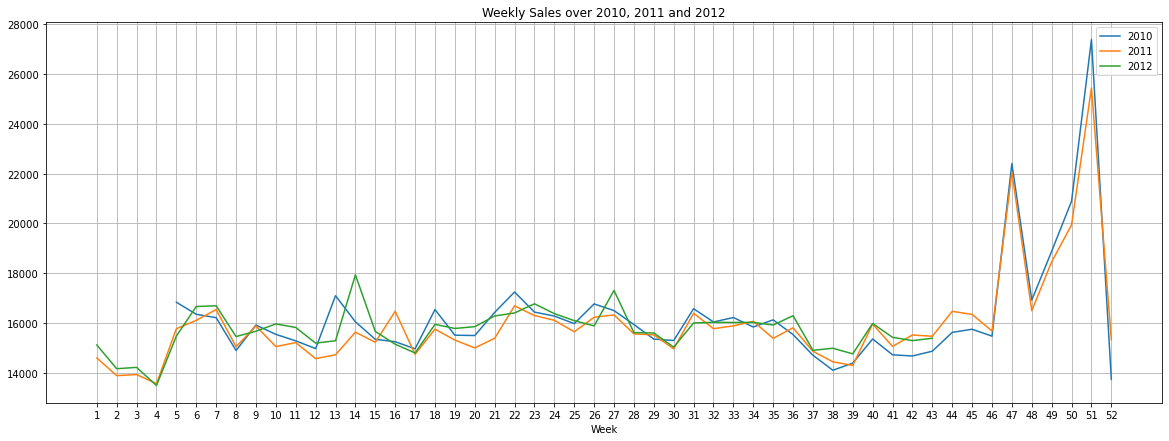

In [7]:
# EDA, data visualizations
weekly_sales = train.groupby(['Year','Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2010 = train.loc[train['Year']==2010].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2011 = train.loc[train['Year']==2011].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2012 = train.loc[train['Year']==2012].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
plt.figure(figsize=(20, 7))
sns.lineplot(weekly_sales2010['Weekly_Sales']['mean'].index, weekly_sales2010['Weekly_Sales']['mean'].values)
sns.lineplot(weekly_sales2011['Weekly_Sales']['mean'].index, weekly_sales2011['Weekly_Sales']['mean'].values)
sns.lineplot(weekly_sales2012['Weekly_Sales']['mean'].index, weekly_sales2012['Weekly_Sales']['mean'].values)
plt.title('Weekly Sales over 2010, 2011 and 2012')
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'])
plt.show()

In [8]:
Y_train = train['Weekly_Sales']
targets= Y_train.copy()
train = train.drop(['Weekly_Sales'],axis=1)
numeric_cols=train.select_dtypes(include=np.number).columns.tolist()
categorical_cols= train.select_dtypes('object').columns.tolist()

In [11]:
# Detect Missing Values and replaced by numerical value
train.isnull().sum()
print('--------- \n')
#test.isnull().sum()
#replace all null values
imputer = SimpleImputer(missing_values = np.NaN, strategy ='mean')
imputer.fit(train[numeric_cols])
train[numeric_cols]=imputer.transform(train[numeric_cols])

--------- 



In [13]:
# Start Modeling
X_train = train[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
X_test= test[['Store','Dept','IsHoliday','Size','Week','Type','Year']]

#splitting training and test dataset with std 75%
train_inputs, val_inputs, train_targets, val_targets = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [17]:
# Random Forest Regressor
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(train_inputs,train_targets)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=3,
                      n_estimators=58)

In [21]:
print('The accurancy score for training data is ',
     RF.score(train_inputs,train_targets))
print ('The accurancy score for testing data is ',
      RF.score(val_inputs, val_targets))

The accurancy score for training data is  0.9951335810194312
The accurancy score for testing data is  0.9773066422166953


In [23]:
# Make and evaluate predictions, evaluate by MSE mean_sqaured_error
train_predict=RF.predict(train_inputs)

def rmse(a,b):
    return mean_squared_error(a,b,squared=False)
rmse(train_targets,train_predict)

1581.1336769648692

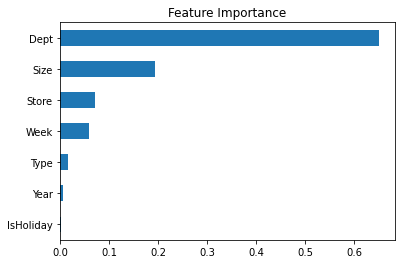

In [26]:
# visualize the important features
feat_importance= pd.Series(RF.feature_importances_,index=train_inputs.columns)
feat_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.show()

In [27]:
#Making Predictions
test_prediction = RF.predict(X_test)
test_prediction

array([29872.23466092, 44904.65380172,  9829.91265887, ...,
       53313.25212069,  6784.38160304,   682.5029454 ])

In [28]:
#convert to csv file
Final = X_test[['Store','Dept','Week']]
test['Weekly_Sales']= test_prediction

In [30]:
sample_submission['Weekly_Sales']=test['Weekly_Sales']
sample_submission.to_csv('submission.csv',index=False)
predicts = pd.read_csv('submission.csv')
predicts

,Id,Weekly_Sales
0,1_1_2012-11-02,29872.234661
1,1_1_2012-11-09,44904.653802
2,1_1_2012-11-16,9829.912659
3,1_1_2012-11-23,35649.707248
4,1_1_2012-11-30,28214.103667
...,...,...
115059,45_98_2013-06-28,3613.685718
115060,45_98_2013-07-05,3376.362848
115061,45_98_2013-07-12,53313.252121
115062,45_98_2013-07-19,6784.381603


In [31]:
#Linear Regression
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
lr.fit(train_inputs,train_targets)

LinearRegression()

In [33]:
Y_pred=lr.predict(train_inputs)
Y_pred

rmse(train_targets,Y_pred)

21674.949850452453

In [36]:
# making prediction
test_pred=lr.predict(X_test)
test_pred

array([13927.49399618, 14039.07649349, 14150.6589908 , ...,
       18250.011901  , 18473.17689562, 18584.75939293])

In [37]:
#conver to csv file
Final = X_test[['Store','Dept','Week']]
test['Weekly_Sales']=test_pred
sample_submission['Weekly_Sales']=test['Weekly_Sales']
sample_submission.to_csv('submission1.csv',index=False)
preds=pd.read_csv('submission1.csv')
preds

,Id,Weekly_Sales
0,1_1_2012-11-02,13927.493996
1,1_1_2012-11-09,14039.076493
2,1_1_2012-11-16,14150.658991
3,1_1_2012-11-23,14262.241488
4,1_1_2012-11-30,14373.823985
...,...,...
115059,45_98_2013-06-28,18026.846906
115060,45_98_2013-07-05,18138.429404
115061,45_98_2013-07-12,18250.011901
115062,45_98_2013-07-19,18473.176896
